In [1]:
import graph_ruggedness_de
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
import sequence_evolution
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import solution_space_simulation
import matplotlib as mpl

QMetaType::registerTypedef: -- Type name 'PyQt_PyObject' previously registered as typedef of 'PyQt_PyObject' [1024], now registering as typedef of '' [-17958193].


### Sequence evolution simulation
The below cell simulates the simulation of amino acid sequences, drawing parameters from uniform distributions of realistic values. The cell has also been converted to functional code in `src.sequence_evolution.sample_sequences`. 

In [42]:
dir_dict = {}
prob_dict = {}
sample_dict = {}

sample_size = 1
for _ in tqdm(enumerate(range(sample_size))):
    try:

        num_nodes = 250
        mean_branch_length = np.random.uniform(0.01, 0.5)
        std_dev_branch_length = np.random.uniform(0.001, 0.1)
        alpha = np.random.uniform(0.1, 0.5)
        model = random.choice(('WAG', 'LG'))
        rate_categoies = 4
        sequence_length = int(np.random.uniform(100, 600))

        sample_info = {
            'num_nodes' : num_nodes,
            'mean_branch_length' : mean_branch_length,
            'std_dev_branch_length' : std_dev_branch_length,
            'alpha' : alpha,
            'model' : model,
            'sequence_length' : sequence_length
        }

        seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                        mean_branch_length=mean_branch_length,
                                                        std_dev_branch_length=std_dev_branch_length,
                                                        alpha=alpha,
                                                        model=model,
                                                        rate_categories=rate_categoies,
                                                        sequence_length=sequence_length
                                                        )
        seq_ls = list(seq_dict.values())
        values = [0]*len(seq_ls)
        G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                            values=values)
    except: 
        continue

G_1 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=1)
G_10 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=10)
G_50 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=50)
G_100 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=100)

0it [00:00, ?it/s]

Computing all vs. all OHE distance matrix.


1it [00:01,  1.97s/it]

Done.
Finding K-nearest neighbors.
Done.
Added 3750 KNN edges.


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_18994/3409874081.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_18994/3409874081.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)


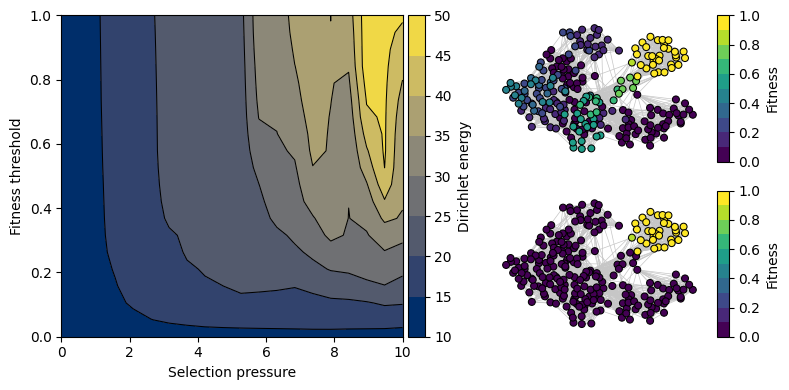

In [43]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

def normalize(values):
    min_val = min(values)
    max_val = max(values)
    if max_val == min_val:
        return [0] * len(values) 
    return [(x - min_val) / (max_val - min_val) for x in values]

G_c = G_1.copy()

# Prepare values, node_colors, and positions
values = [node[1]['value'] for node in G_c.nodes(data=True)]
values = normalize(values)
viridis = plt.cm.get_cmap('viridis', 10)
node_colors = [viridis(value) for value in values]
pos = nx.spring_layout(G_c, k=0.5)

#Solution space simulation
a_vals = np.linspace(0, 10, 20)
t_vals = np.linspace(0, 1, 20)

de_dict = {}
for i in a_vals:
    for j in t_vals:
        
        transformed_values = [solution_space_simulation.transform(fitness=value, a=i, t=j) for value in values]
        for idx, (node, data) in enumerate(G_c.nodes(data=True)):
            data['value'] = transformed_values[idx]

        de_dict[(i, j)] = graph_ruggedness_de.compute_dirichlet_energy(G=G_c)

# Prepare data for contour plot
a = np.array([key[0] for key in de_dict.keys()])
j = np.array([key[1] for key in de_dict.keys()])
z = np.array(list(de_dict.values()))
x_unique = np.unique(a)
y_unique = np.unique(j)
X, Y = np.meshgrid(x_unique, y_unique)
Z = z.reshape(len(y_unique), len(x_unique))

# Create figure and grid layout
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1.5, 1])

ax1 = fig.add_subplot(gs[:, 0])  # Contour plot
ax2 = fig.add_subplot(gs[0, 1])  # First network graph
ax3 = fig.add_subplot(gs[1, 1])  # Second network graph

# Plot contour plot
cp = ax1.contourf(X, Y, Z, cmap='cividis')
cp_lines = ax1.contour(X, Y, Z, colors='black', linewidths=0.75)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(cp, cax=cax1)
cbar1.set_label('Dirichlet energy')
ax1.set_xlabel('Selection pressure')
ax1.set_ylabel('Fitness threshold')

# Plot first network graph
nx.draw(G_c, pos, node_color=node_colors, with_labels=False, edgecolors='black',
        node_size=25, width=0.5, edge_color='#C6C6C6', linewidths=0.75, ax=ax2)
sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(sm, cax=cax2)
cbar2.set_label('Fitness')

# Update G_c for maximally rugged parameters and prepare node_colors
G_c = G_1.copy()

#Updating fitnesses
max_key = max(de_dict, key=de_dict.get)
values = [node[1]['value'] for node in G_c.nodes(data=True)]
values = normalize(values)
transformed_values = [solution_space_simulation.transform(fitness=value, a=max_key[0], t=max_key[1]) for value in values]
for idx, (node, data) in enumerate(G_c.nodes(data=True)):
    data['value'] = transformed_values[idx]

values = [node[1]['value'] for node in G_c.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)
node_colors = [viridis((value - min(values)) / (max(values) - min(values))) for value in values]

# Plot second network graph
nx.draw(G_c, pos, node_color=node_colors, with_labels=False, edgecolors='black',
        node_size=25, width=0.5, edge_color='#C6C6C6', linewidths=0.75, ax=ax3)
sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
sm.set_array([])
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(sm, cax=cax3)
cbar3.set_label('Fitness')

plt.tight_layout()
plt.savefig('figures/Figure_6alt/DE_sol_space_simulation.pdf')
plt.show()